### Assignment 2 

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

### Initialization

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# load data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

input_dim = 3 * 32 * 32
output_dim = 10
batch_size = 50

Files already downloaded and verified


### Define model and functions

In [5]:
device

device(type='cpu')

In [0]:
class LRModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden = hidden
        self.seq = torch.nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, output_dim)
                                   )
    def forward(self, x):
        return self.seq(x)

In [0]:
    
def train(model, trainset, lr=0.001, momentum=0.9, batch_size=32, epochs=2):
    
    # create trainloader and testloader
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                      shuffle=True, num_workers=2)

    # create optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    
    # define loss function
    criterion = nn.CrossEntropyLoss()
    
    num_iters = 0
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            images, labels = data
            
            # send to device
            images, labels = images.to(device), labels.to(device)

            # reshape images
            inputs = images.view(-1, model.input_dim)

            # zero gradients
            optimizer.zero_grad()

            # forward, backward and optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            num_iters += 1
            losses.append(loss.item())
            
            # print statistics every 1000th iteration
            if num_iters % 1000 == 0:
                print('Iteration: {0}, Epoch: {1}, loss: {2:.3f}'.format(num_iters, epoch, loss.item()))
    
    # losses per iteration
    return losses
    
def test(model, dataset, batch_size=32):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    total = len(dataset)
    correct = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            
            # send to device
            images, labels = images.to(device), labels.to(device)
            
            inputs = images.view(-1, model.input_dim)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    
    return 100 * correct / total;

def k_fold_cross_validate(trainset, lrs, hiddens, num_folds=5, batch_size=32, epochs=2):
    
    indices_fold = np.array_split(np.arange(len(trainset)), num_folds)
    best_acc = 0.0
    best_params = {}
    
    for lr in lrs:
        for hidden in hiddens:
            print("[learning_rate: {0}, hidden_layer: {1}]".format(lr, hidden))
            acc_sum = 0.0
            for k in range(num_folds):
                model = LRModel(input_dim, output_dim, hidden)
                model.to(device)
                
                valid_indices = indices_fold[k]
                train_indices = np.hstack(indices_fold[:k] + indices_fold[k+1:])

                train_fold = torch.utils.data.Subset(trainset, train_indices)
                valid_fold = torch.utils.data.Subset(trainset, valid_indices)

                train(model, train_fold, batch_size=batch_size, epochs=epochs)
                acc = test(model, valid_fold)
                acc_sum += acc
                print("Accuracy on validation set: {0:.3f}\n".format(acc))
            
            avg_acc = acc_sum / num_folds
            
            if avg_acc > best_acc:
                best_acc = avg_acc
                best_params['lr'] = lr
                best_params['hidden'] = hidden
                
            print("[Average accuracy across {0} folds for lr={1} and hidden={2} is {3:.3f}%]\n".format(
                  num_folds, lr, hidden, avg_acc))
    return best_params

def plot_losses(losses):
    x = list(range(len(losses)))
    y = losses
    plt.title("Loss per Iteration")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.plot(x, losses)
    plt.show()

### K-Fold Cross Validation

In [0]:
lrs = [0.001, 0.0001]
hiddens = [300, 500]
best_params = k_fold_cross_validate(trainset, lrs, hiddens, batch_size=50)
print("Best parameters: ", best_params)

[learning_rate: 0.001, hidden_layer: 300]
Iteration: 1000, Epoch: 1, loss: 1.559
Accuracy on validation set: 44.100

Iteration: 1000, Epoch: 1, loss: 1.537
Accuracy on validation set: 42.840

Iteration: 1000, Epoch: 1, loss: 1.870
Accuracy on validation set: 43.860

Iteration: 1000, Epoch: 1, loss: 1.633
Accuracy on validation set: 43.330

Iteration: 1000, Epoch: 1, loss: 1.476
Accuracy on validation set: 42.830

[Average accuracy across 5 folds for lr=0.001 and hidden=300 is 43.392%]

[learning_rate: 0.001, hidden_layer: 500]
Iteration: 1000, Epoch: 1, loss: 1.652
Accuracy on validation set: 43.710

Iteration: 1000, Epoch: 1, loss: 1.667
Accuracy on validation set: 43.180

Iteration: 1000, Epoch: 1, loss: 1.792
Accuracy on validation set: 43.830

Iteration: 1000, Epoch: 1, loss: 1.852
Accuracy on validation set: 43.790

Iteration: 1000, Epoch: 1, loss: 1.701
Accuracy on validation set: 43.390

[Average accuracy across 5 folds for lr=0.001 and hidden=500 is 43.580%]

[learning_rate: 0.

### Train with best hyperparameters

In [0]:
model = LRModel(input_dim, output_dim, hidden=best_params['hidden'])
model.to(device)
losses = train(model, trainset, lr=best_params['lr'], batch_size=batch_size, epochs=2)

Iteration: 1000, Epoch: 0, loss: 1.953
Iteration: 2000, Epoch: 1, loss: 1.759
Iteration: 3000, Epoch: 2, loss: 1.613
Iteration: 4000, Epoch: 3, loss: 1.724
Iteration: 5000, Epoch: 4, loss: 1.554
Iteration: 6000, Epoch: 5, loss: 1.269
Iteration: 7000, Epoch: 6, loss: 1.325
Iteration: 8000, Epoch: 7, loss: 1.392
Iteration: 9000, Epoch: 8, loss: 1.360
Iteration: 10000, Epoch: 9, loss: 1.427


In [0]:
train_acc = test(model, trainset, batch_size=batch_size)
test_acc = test(model, testset, batch_size=batch_size)
print("Train accuracy: ", train_acc)
print("Test accuracy:", test_acc)

Train accuracy:  51.486
Test accuracy: 48.79


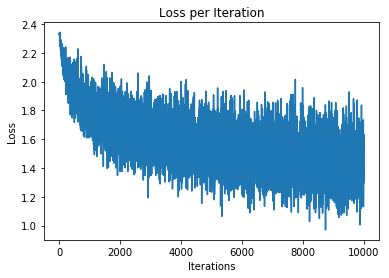

In [0]:
plot_losses(losses)